In [2]:
# Library
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
from google.colab import files
from PIL import Image

In [3]:
# Paths
drive.mount("/content/drive")
train_dir = "/content/drive/MyDrive/Collage/Materials/Proyek Semester/Herbio/Dataset Tanaman Herbal/Data Training"
test_dir = "/content/drive/MyDrive/Collage/Materials/Proyek Semester/Herbio/Dataset Tanaman Herbal/Data Testing"

Mounted at /content/drive


In [4]:
# Image Augmentation & Normalisasi
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    zoom_range = .2,
    horizontal_flip = True,
    validation_split = .2         # 20% untuk validasi
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size = (224, 224), batch_size = 32, class_mode = "categorical", subset = "training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir, target_size = (224, 224), batch_size = 32, class_mode = "categorical", subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size = (224, 224), batch_size = 32, class_mode = "categorical", shuffle = False
)

Found 640 images belonging to 10 classes.
Found 160 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [5]:
# Label Kelas
class_labels = list(train_generator.class_indices.keys())

In [6]:
# Base Model MobileNetV2 + Fine-Tuning
base_model = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = "imagenet"
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Bekukan semua layer terlebih dahulu
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Fine-tune 20 layer terakhir
    layer.trainable = False

In [8]:
# Bangun Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(.3)(x)
predictions = Dense(len(class_labels), activation = "softmax")(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [9]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 1,371,338 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [10]:
# Early Stopping
early_stop = EarlyStopping(patience = 8, restore_best_weights = True)

In [11]:
# Training
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 50,
    callbacks = [early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 556s 27s/step - accuracy: 0.3751 - loss: 1.8614 - val_accuracy: 0.7500 - val_loss: 0.7715
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 8s/step - accuracy: 0.9236 - loss: 0.4337 - val_accuracy: 0.8625 - val_loss: 0.4216
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.9482 - loss: 0.1646 - val_accuracy: 0.9000 - val_loss: 0.2893
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.9924 - loss: 0.0902 - val_accuracy: 0.9500 - val_loss: 0.1855
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 198s 8s/step - accuracy: 0.9912 - loss: 0.0626 - val_accuracy: 0.9563 - val_loss: 0.1464
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 161s 8s/step - accuracy: 0.9852 - loss: 0.0533 - val_accuracy: 0.9688 - val_loss: 0.1200
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.9907 - loss: 0.0479 - val_accuracy: 0.9812 - val_loss: 0.0846
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.9988 - loss: 0.0208 - val_accuracy: 0.9500 - 

In [12]:
# Evaluasi
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi pada data testing: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 89s 13s/step - accuracy: 0.9654 - loss: 0.1054
Akurasi pada data testing: 0.95


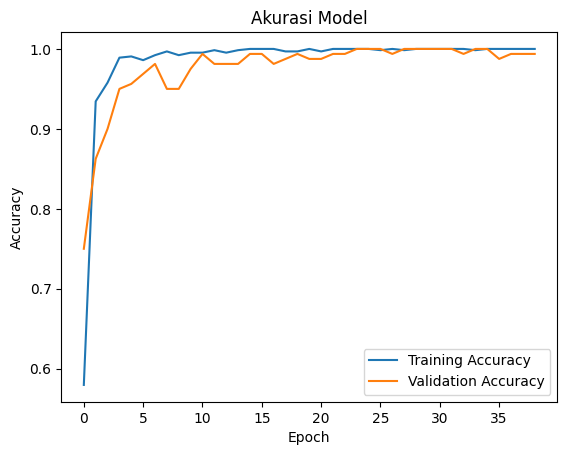

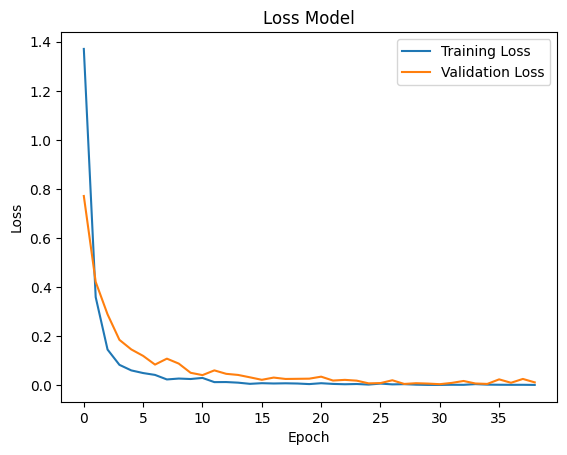

In [13]:
# Plot Akurasi dan Loss
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Akurasi Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Loss Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step


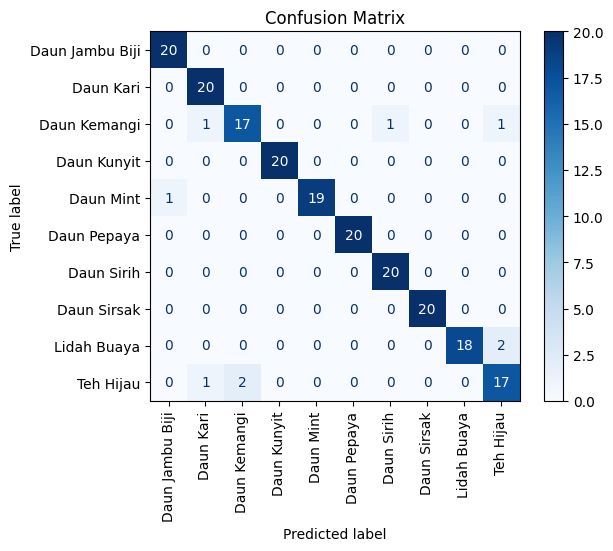

In [14]:
# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis = 1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = class_labels)
cmd.plot(cmap = "Blues", xticks_rotation = "vertical")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Simpan Model
model.save("/content/drive/MyDrive/Collage/Materials/Proyek Semester/Herbio/Dataset Tanaman Herbal/mobilenetv2_finetune_model_daun.h5")

Saving jambu biji (1).JPG to jambu biji (1).JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


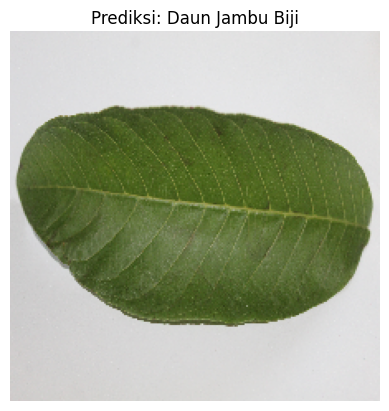

Hasil Prediksi: Daun Jambu Biji


In [16]:
# Fungsi untuk prediksi gambar tunggal
def process_and_predict(img_path):
    img = image.load_img(img_path, target_size = (224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis = 0)
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction, axis = 1)[0]
    predicted_label = class_labels[class_idx]

    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label

# Upload gambar untuk prediksi
uploaded = files.upload()
for fn in uploaded.keys():
    result = process_and_predict(fn)
    print(f"Hasil Prediksi: {result}")